# "High-frequency trading in a limit order book" - Avellaneda and Stoikov, 2006

In [1]:
import pandas as pd
import numpy as np
import price_series_generator
import plot_utils

# Set Parameters

In [2]:
PATHS = 1000
START_PRICE = 100
SIGMA = 2
STEPS = 200
dt = (1 / STEPS)
GAMMA = 0.1
K = 1.5
A = 140
optimal_spread = 2 * np.log(1 + GAMMA / K) / GAMMA
spread = optimal_spread / 2

# Generate Price Series

In [3]:
price_array = price_series_generator.generate_price_series(
    initial_value=START_PRICE,
    sigma=SIGMA,
    paths=PATHS,
    steps=STEPS,
)

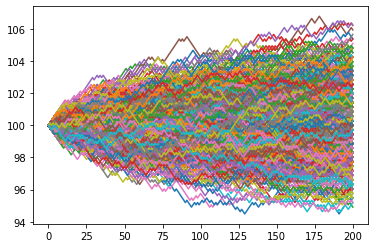

In [4]:
plot_utils.plot_price(price_array.T)

# Reservation Price

In [5]:
def get_reservation_price(
        price: float,
        inventory: float,
        gamma: float,
        sigma: float,
        time_to_end: float
) -> float:
    reservation_price = price - inventory * gamma * (sigma ** 2) * time_to_end
    return reservation_price

# Market Impact Model

In [6]:
class MarketImpactModel:
    def __init__(self, A: float, K: float, dt: float):
        self.K = K
        self.A = A
        self.dt = dt

    def bid_ask_spread_touch(self, bid_spread: float, ask_spread: float) -> tuple[bool, bool]:
        bid_touch = True if bid_spread < 0 else self.__spread_touch(bid_spread)
        ask_touch = True if ask_spread < 0 else self.__spread_touch(ask_spread)
        return bid_touch, ask_touch

    def __spread_touch(self, spread: float) -> bool:
        touch_prob = self.A * np.exp(-self.K * spread) * self.dt
        touch_prob = max(0, min(touch_prob, 1))
        touch = np.random.choice([True, False], p=[touch_prob, 1 - touch_prob])
        return touch

# Market Maker

In [7]:
class MarketMaker:
    def __init__(self):
        self.cash = 0
        self.__inventory = 0

    def get_inventory(self):
        return self.__inventory

    def add_inventory(self):
        self.__inventory += 1

    def subtract_inventory(self):
        self.__inventory -= 1

    def ask_touch(self, price: float, spread: float):
        self.subtract_inventory()
        self.cash += (price + spread)

    def bid_touch(self, price: float, spread: float):
        self.add_inventory()
        self.cash -= (price - spread)

    def get_final_profit(self, final_price) -> float:
        profit = self.cash
        profit += self.__inventory * final_price
        return profit

# Inventory Strategy

In [8]:
class InventoryStrategy:
    def __init__(self, spread: float, market_impact_model: MarketImpactModel, gamma: float, sigma: float, steps: int):
        self.market_maker = MarketMaker()
        self.spread = spread
        self.market_impact_model = market_impact_model
        self.gamma = gamma
        self.sigma = sigma
        self.steps = steps

    def step(self, price: float, step_i: int) -> tuple[float, float]:
        reservation_price = get_reservation_price(
            price=price,
            inventory=self.get_inventory(),
            gamma=self.gamma,
            sigma=self.sigma,
            time_to_end=1 - step_i / self.steps
        )
        bid_spread = self.spread - (reservation_price - price)
        ask_spread = self.spread + (reservation_price - price)

        bid_touch, ask_touch = self.market_impact_model.bid_ask_spread_touch(bid_spread, ask_spread)

        if bid_touch:
            self.market_maker.bid_touch(price, bid_spread)
        if ask_touch:
            self.market_maker.ask_touch(price, ask_spread)

        bid_price = reservation_price - self.spread
        ask_price = reservation_price + self.spread
        return bid_price, ask_price

    def get_inventory(self) -> float:
        return self.market_maker.get_inventory()

    def get_final_profit(self, price: float) -> float:
        return self.market_maker.get_final_profit(price)

# Symmetric Strategy

In [9]:
class SymmetricStrategy:
    def __init__(self, spread: float, market_impact_model: MarketImpactModel):
        self.market_maker = MarketMaker()
        self.spread = spread
        self.market_impact_model = market_impact_model

    def step(self, price: float):
        bid_touch, ask_touch = self.market_impact_model.bid_ask_spread_touch(self.spread, self.spread)

        if bid_touch:
            self.market_maker.bid_touch(price, self.spread)
        if ask_touch:
            self.market_maker.ask_touch(price, self.spread)

    def get_final_profit(self, price: float) -> float:
        return self.market_maker.get_final_profit(price)

# 1000 Paths Simulation 

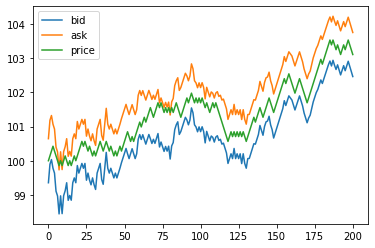

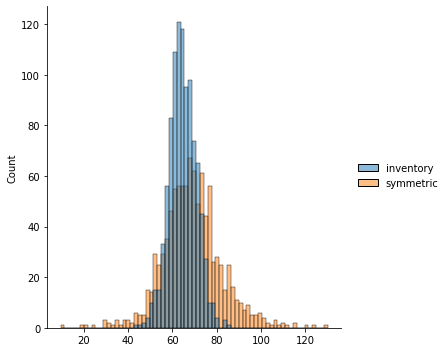

In [10]:
market_impact_model = MarketImpactModel(A=A, K=K, dt=dt)

optimal_bid_ask_price_df = pd.DataFrame(columns=['bid', 'ask', 'price'], dtype=float)
final_profit_df = pd.DataFrame(columns=['inventory', 'symmetric'], dtype=float)
for path_i, single_price_series in enumerate(price_array):
    inventory_strategy = InventoryStrategy(spread, market_impact_model, gamma=GAMMA, sigma=SIGMA, steps=STEPS)
    symmetric_strategy = SymmetricStrategy(spread, market_impact_model)
    final_price = 0
    for step_i, price in enumerate(single_price_series):
        # Inventory Strategy ===========================================
        opt_bid, opt_ask = inventory_strategy.step(price, step_i)
        # ==============================================================

        # Symmetric Strategy ===========================================
        symmetric_strategy.step(price)
        # ==============================================================

        if path_i == 0:
            optimal_bid_ask_price_df.loc[len(optimal_bid_ask_price_df)] = [opt_bid, opt_ask, price]
        final_price = price

    inventory_strategy_profit = inventory_strategy.get_final_profit(final_price)
    symmetric_strategy_profit = symmetric_strategy.get_final_profit(final_price)
    final_profit_df.loc[len(final_profit_df)] = [inventory_strategy_profit, symmetric_strategy_profit]

plot_utils.plot_compare_price(optimal_bid_ask_price_df)    # 첫번째만 출력
plot_utils.plot_compare_histogram(final_profit_df)

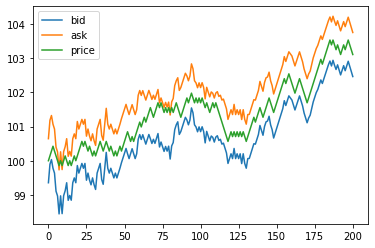

In [11]:
plot_utils.plot_compare_price(optimal_bid_ask_price_df)